# В этом ноутбуке мы обучили классическую полносвязную сеть из одного слоя на задачу классификации

In [11]:
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm as tqdma

Импортируем данные из первого ноутбука

In [12]:
with open('embedded_states.pickle', 'rb') as f:
    data_dict = pkl.load(f)
    data, label = data_dict['embeddings'], data_dict['labels']

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm as tqdma

CONFIG = {
        'BATCH_SIZE' : 200,
        'LR' : 1e-4,
        'WD' : 1e-8,
        'EPOCHS': 1500
        }

In [14]:
x_train, x_test, y_train, y_test = train_test_split(data, label, train_size=0.8, random_state=52)
x_test = torch.FloatTensor(x_test)
x_train = torch.FloatTensor(x_train)
y_test = torch.LongTensor(y_test)
y_train = torch.LongTensor(y_train)

In [15]:
loader_test = torch.utils.data.DataLoader(dataset = torch.cat((x_test, y_test.reshape(-1,1)), axis=1),
                                          batch_size = CONFIG['BATCH_SIZE'],
                                          shuffle = True)

loader_train = torch.utils.data.DataLoader(dataset = torch.cat((x_train, y_train.reshape(-1,1)), axis=1),
                                           batch_size = CONFIG['BATCH_SIZE'],
                                           shuffle = True)

Простейшая сеть, состоящая из одного линейного слоя

In [16]:
class SimpleClf(torch.nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(embedding_size, 2),
        )
 
    def forward(self, x):
        output = self.layers(x)
        return output

In [17]:
model = SimpleClf(embedding_size=384)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = CONFIG['LR'],
                             weight_decay = CONFIG['WD'])

In [18]:
epochs = CONFIG['EPOCHS']
dict_list = []
for epoch in tqdma(range(epochs)):
    for batch_train, batch_test in zip(loader_train, loader_test):
        X_train, Y_train = batch_train[:,:-1], batch_train[:,-1].long()
        X_test, Y_test = batch_test[:,:-1], batch_test[:,-1].long()
        model.train()
        output_train = model(X_train)
        
        loss_train = loss_function(output_train, Y_train)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            output_test = model(X_test)
            loss_test = loss_function(output_test, Y_test).detach().numpy()
        temp_dict = {'Epoch': epoch,'loss_train': loss_train.detach().numpy(), 'loss_test': loss_test}
        dict_list.append(temp_dict)

with torch.no_grad():
    output_test = model(x_test)
    output_train = model(x_train)
    softmax = torch.nn.Softmax(dim=1)
    pred_test = softmax(output_test)
    pred_train = softmax(output_train)
    print('test score:', accuracy_score(y_test, pred_test.argmax(dim=1)))
    print('train score:', accuracy_score(y_train, pred_train.argmax(dim=1)))

df_learning_o = pd.DataFrame(dict_list)

  0%|          | 0/1500 [00:00<?, ?it/s]

test score: 0.9047619047619048
train score: 0.9464285714285714


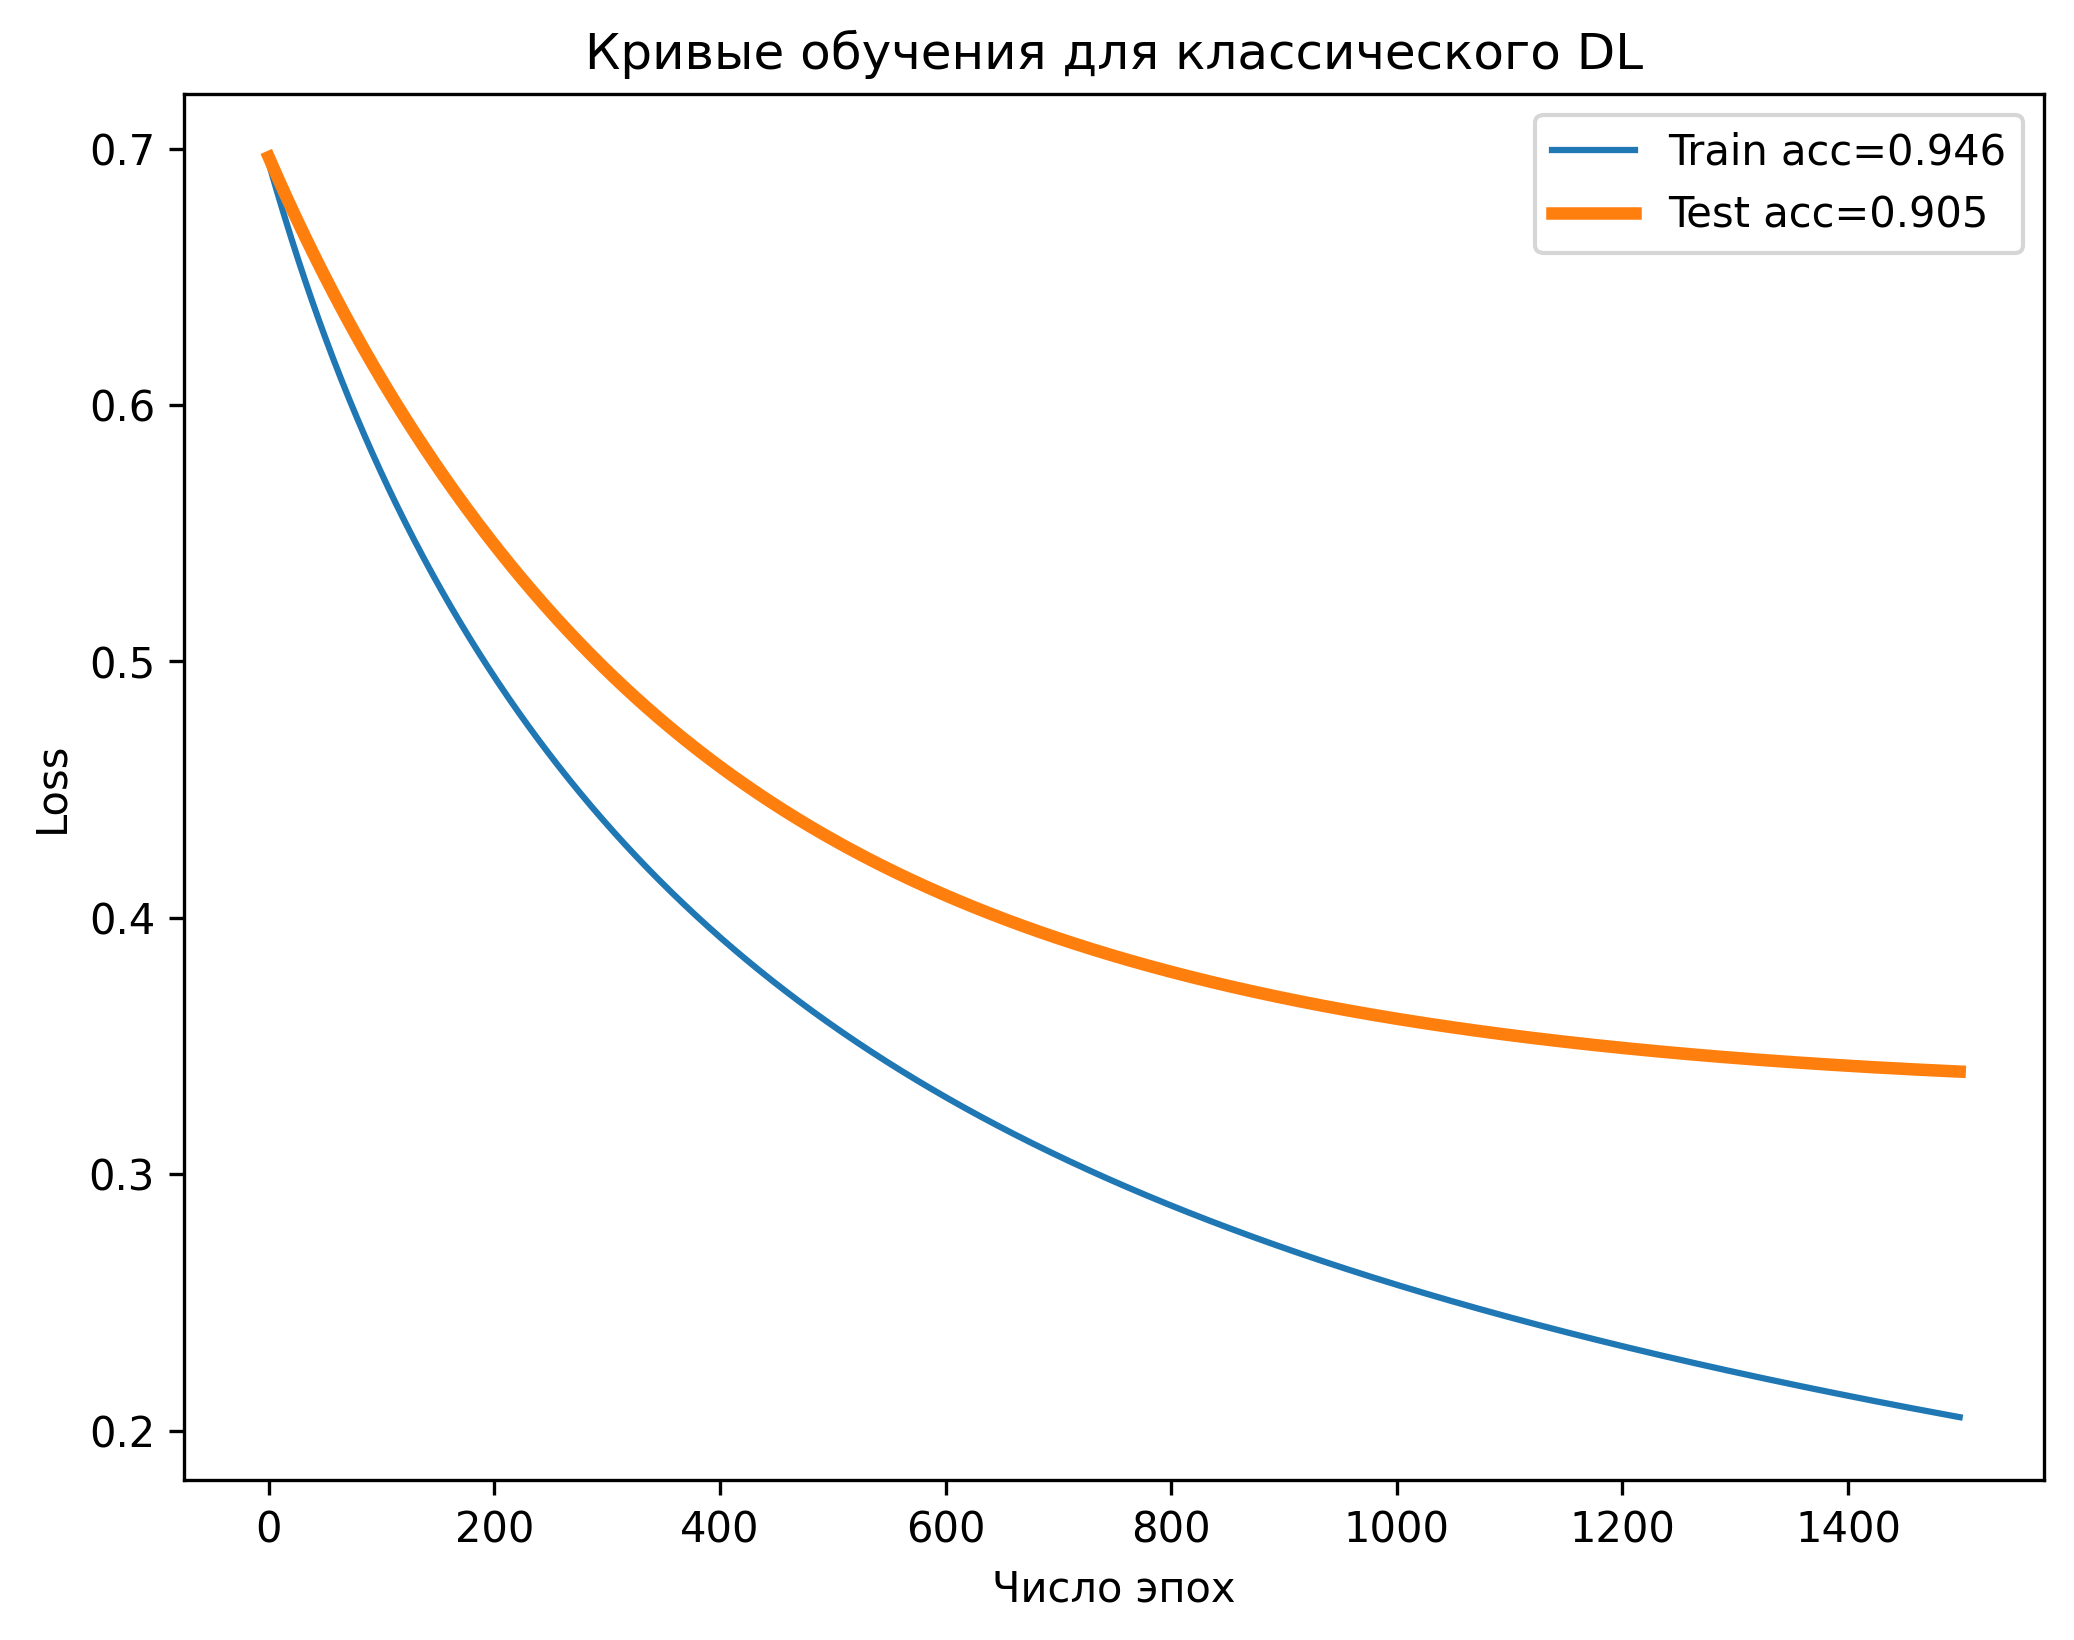

In [20]:
plt.figure(figsize=(8,6), dpi=300)
plt.plot(df_learning_o['loss_train'], label=f'Train acc={round(accuracy_score(y_train, pred_train.argmax(dim=1)), 3)}')
plt.plot(df_learning_o['loss_test'], label=f'Test acc={round(accuracy_score(y_test, pred_test.argmax(dim=1)), 3)}', linewidth=3)
plt.ylabel('Loss')
plt.title('Кривые обучения для классического DL')
plt.xlabel('Число эпох')
plt.legend()

Обработка данных на 9 утра

In [29]:
with open('NEW_DATA.pickle', 'rb') as f:
    NEW_DATA = pkl.load(f)
    new_data, new_label = NEW_DATA['embeddings'], NEW_DATA['labels']
new_label = np.array([0 if y=='-' else 1 for y in new_label])

In [30]:
with torch.no_grad():
    output_new = model(torch.FloatTensor(new_data))
    softmax = torch.nn.Softmax(dim=1)
    pred_new = softmax(output_new)
    print('Validation classic score:', accuracy_score(new_label, pred_new.argmax(dim=1)))

Validation classic score: 0.72
